# Contour Tests

In [1]:
# Type imports
from typing import Any, Dict, List, Tuple

# Standard Libraries
from pathlib import Path
from collections import Counter, defaultdict
from dataclasses import dataclass, field, asdict
from math import sqrt, pi, sin, cos, tan, radians
from math import isnan
from statistics import mean
from itertools import zip_longest

# Shared Packages
import pandas as pd
import numpy as np
import xlwings as xw

import pygraphviz as pgv
import networkx as nx

In [2]:
from types_and_classes import *

## functions for creating contours

In [3]:

def make_slice_table(slice_data: pd.DataFrame)->pd.DataFrame:
    slice_table = slice_data.unstack('ROI Num')
    slice_table.columns = slice_table.columns.droplevel()
    return slice_table


In [4]:
def slice_spacing(contour):
    # Index is the slice position of all slices in the image set
    # Columns are structure IDs
    # Values are the distance (INF) to the next contour
    inf = contour.dropna().index.min()
    sup = contour.dropna().index.max()
    contour_range = (contour.index <= sup) & (contour.index >= inf)
    slices = contour.loc[contour_range].dropna().index.to_series()
    gaps = slices.shift(-1) - slices
    return gaps

In [5]:
def c_type(obj):
    if isinstance(obj, StructureSlice):
        n = str(type(obj.contour))
        s = n.replace('shapely.geometry.', '')
    else:
        s = str(type(obj))
    s = s.replace('<class ', '')
    s = s.replace('>', '')
    return s

In [6]:
def relate_structs(slice_table: pd.DataFrame, structures: StructurePair) -> int:
    slice_structures = slice_table.loc[:, [structures[0],
                                           structures[1]]]
    # Remove Slices that have neither structure.
    slice_structures.dropna(how='all', inplace=True)
    # For slices that have only one of the two structures, replace the nan
    # values with empty polygons for duck typing.
    slice_structures.fillna(StructureSlice([]), inplace=True)
    # Get the relationships between the two structures for all slices.
    relation_seq = slice_structures.agg(relate, structures=structures,
                                        axis='columns')
     # Get the overall relationship for the two structures by merging the
    # relationships for the individual slices.
    relation_binary = merge_rel(relation_seq)
    return relation_binary

### Make test structures

In [7]:
# 6 cm x 6 cm box
box6 = shapely.Polygon(box_points(6))
slices = make_slice_list(5)
slices_1 = make_contour_slices(1, slices, [box6])

# 4 cm x 4 cm box
box4 = shapely.Polygon(box_points(4))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_2 = make_contour_slices(2, slices, [box4])

# 6 cm x 6 cm box offset right by 3 cm
offset_box6 = shapely.Polygon(box_points(6, offset_x=3))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_3 = make_contour_slices(3, slices, [offset_box6])

# 6 cm x 6 cm box with 4cm x 4 cm hole
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
slices = make_slice_list(5, start=0.2)
slices_4 = make_contour_slices(4, slices, [box6, box4])

# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_5 = make_contour_slices(5, slices, [box2a, box2b])

# 2 cm x 2 cm box offset inf by 0.3 cm
slices = make_slice_list(5, start=-0.3)
slices_6 = make_contour_slices(6, slices, [offset_box6])


In [8]:
# combine the slice data
slice_data = pd.concat([slices_1, slices_2, slices_3, slices_4, slices_5,
                        slices_6])
# convert slice data into a table of slices and structures
slice_table = make_slice_table(slice_data)

In [13]:
relationship_1_2 = Relationship(slice_table, (1, 2))
print(relationship_1_2.relationship_type)

TypeError: relate() got an unexpected keyword argument 'structures'

In [ ]:
relationship_1_2 = Relationship(slice_table, (1, 6))
print(relationship_1_2.relationship_type)

RelationshipType.OVERLAPS


In [ ]:
relationship_1_2 = Relationship(slice_table, (4, 2))
print(relationship_1_2.relationship_type)

RelationshipType.UNKNOWN


In [ ]:
relation_binary = relate_structs(slice_table, (4, 2))
bin(relation_binary)

'0b111001111111001111001011111'

**Expecting Interior Borders**

```
111 001 111 | 111 001 111 | 001 011 111
              T** *T* *** | FF* FT* ***    Interior Borders
              T** *F* F** | FF* FT* ***    Surrounds
              T*F *F* *** | FF* FT* ***    Embeds
```

***Confines / Exsects***
The interior boundary of one shape *a* and the exterior boundary of another shape *b* have more than one point in common, but their interiors do not intersect.

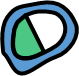

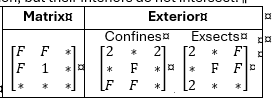

FF2F112F2
212F1FFF2


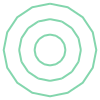

In [ ]:
circle_6 = shapely.Polygon(circle_points(6))
circle_4 = shapely.Polygon(circle_points(4))
circle_2 = shapely.Polygon(circle_points(2))
island_shape = shapely.union(shapely.difference(circle_6, circle_4),circle_2)
island_border = shapely.difference(circle_4, circle_2)

print(shapely.relate(island_shape, island_border))

interior = shapely.Polygon(island_shape.geoms[0].interiors[0])
print(shapely.relate(interior, island_border))
shapely.union(island_shape.boundary, island_border.boundary)

```
111 001 111 | 111 001 111 | 001 011 111
              T** *T* *** | FF* FT* ***    Interior Borders
              T** *F* F** | FF* FT* ***    Surrounds
              T*F *F* *** | FF* FT* ***    Embeds

              212 F1F FF2 | FF2 F11 2F2

              212 FF1 FF2 | FF2 F11 2F2
```

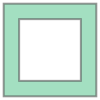

In [ ]:
poly_2 = StructureSlice([box4])
poly_4 = StructureSlice([box6, box4])
poly_4.contour

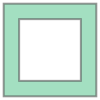

In [ ]:
shapely.difference(poly_4.contour,poly_2.contour)

In [ ]:
shapely.relate(poly_4.contour,poly_2.contour)

'FF2F112F2'

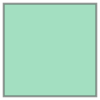

In [ ]:
poly_4.exterior

In [ ]:
shapely.relate(poly_4.exterior,poly_2.contour)

'212FF1FF2'

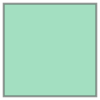

In [ ]:
shapely.union(poly_4.contour,poly_2.contour)

In [ ]:
circle_6 = shapely.Polygon(circle_points(6))
circle_4 = shapely.Polygon(circle_points(4))
circle_2 = shapely.Polygon(circle_points(2))
circle_with_hole = shapely.difference(circle_6, circle_4)
inner_circle = circle_4

print(shapely.relate(circle_with_hole, inner_circle))

interior = shapely.Polygon(circle_with_hole.geoms[0].interiors[0])
print(shapely.relate(interior, inner_circle))
shapely.union(island_shape.boundary, island_border.boundary)

FF2F112F2


AttributeError: 'Polygon' object has no attribute 'geoms'

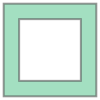

In [ ]:
shapely.difference(poly_4.exterior,poly_2.contour)

In [ ]:
relation_binary = relate_structs(slice_table, (1, 2))
bin(relation_binary)

In [ ]:
relation_binary = relate_structs(slice_table, (1, 6))
bin(relation_binary)

## Create slice index


In [ ]:
slice_table = slice_data.index.to_frame()
slice_table = slice_table['Slice Index'].unstack('ROI Num')
contour_slices = slice_table.apply(slice_spacing)

In [ ]:
def build_slice_table(contour_sets)->pd.DataFrame:
    def form_table(slice_index):
        slice_index.reset_index(inplace=True)
        slice_index.sort_values('Slice', inplace=True)
        slice_index.set_index(['Slice','StructureID'], inplace=True)
        slice_table = slice_index.unstack()
        slice_table.columns = slice_table.columns.droplevel()
        return slice_table

    slice_index = build_contour_index(contour_sets)
    slice_table = form_table(slice_index)
    contour_slices = slice_table.apply(slice_spacing)
    return contour_slices

In [ ]:
def build_contour_index(contour_sets: Dict[int, ContourSet])->pd.DataFrame:
    '''Build an index of structures in a contour set.

    The table columns contain the structure names, the ROI number, and the
    slice positions where the contours for that structure are located.  There
    is one row for each slice and structure on that slice.  Multiple contours
    for a single structure on a given slice, have only one row in teh contour
    index

    Args:
        contour_sets (Dict[int, RS_DICOM_Utilities.ContourSet]): A dictionary
            of structure data.

    Returns:
        pd.DataFrame: An index of structures in a contour set indication which
            slices contains contours for each structure.
    '''
    slice_ref = {}
    name_ref = {}
    for structure in contour_sets.values():
        slice_ref[structure.roi_num] = list(structure.contours.keys())
        name_ref[structure.roi_num] = structure.structure_id
    slice_seq = pd.Series(slice_ref).explode()
    slice_seq.name = 'Slice'
    name_lookup = pd.Series(name_ref)
    name_lookup.name = 'StructureID'
    slice_lookup = pd.DataFrame(name_lookup).join(slice_seq, how='outer')
    return slice_lookup

ContourData: Table
	Index: AutoInteger
	Columns:
		ROI_Num,
		SliceIndex,
		Area,
		Contour
Generated by: Read Contour Data

StructureData: Series:
	Index: ROI_Num, SliceIndex
	Values: StructureSlice
Generated by: Build StructureSet


In [ ]:
box1_def = {
        'struct_id': 'GTV',
        'roi': 38,
        'structure_type': 'GTV',
        'structure_code': 'GTVp',
        'structure_code_meaning': 'Primary Gross Tumor Volume',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (255, 0, 0),
        'volume': 8.03,
        'length': 2.6,
        'sup_slice': -0.4,
        'inf_slice': -3,
        'center_of_mass': (-5.36,  9.71, -1.63)
        }

structure_def = Structure(**box1_def)


In [ ]:
structure_def = [
    {
        'struct_id': 'GTV',
        'roi': 38,
        'structure_type': 'GTV',
        'structure_code': 'GTVp',
        'structure_code_meaning': 'Primary Gross Tumor Volume',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (255, 0, 0),
        'volume': 8.03,
        'length': 2.6,
        'sup_slice': -0.4,
        'inf_slice': -3,
        'center_of_mass': (-5.36,  9.71, -1.63)
        },{
        'struct_id': 'CTV',
        'roi': 24,
        'structure_type': 'GTV',
        'structure_code': 'ITV',
        'structure_code_meaning': 'Internal Target Volume',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (255, 255, 0),
        'volume': 34.45,
        'length': 3.6,
        'sup_slice': 0,
        'inf_slice': -3.6,
        'center_of_mass': (-5.34,  9.79, -1.61)
        },{
        'struct_id': 'PTV',
        'roi': 30,
        'structure_type': 'PTV',
        'structure_code': 'PTVp',
        'structure_code_meaning': 'Primary Planning Target Volume',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (0, 255, 255),
        'volume': 74.649,
        'length': 4.6,
        'sup_slice': 0.6,
        'inf_slice': -4.0,
        'center_of_mass': (-5.36,  9.78, -1.59)
        },{
        'struct_id': 'eval PTV',
        'roi': 41,
        'structure_type': 'PTV',
        'structure_code': 'PTVp',
        'structure_code_meaning': 'Primary Planning Target Volume',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (0, 255, 255),
        'volume': 74.649,
        'length': 4.6,
        'sup_slice': 0.6,
        'inf_slice': -4.0,
        'center_of_mass': (-5.36,  9.78, -1.59)
        },{
        'struct_id': 'BODY',
        'roi': 1,
        'structure_type': 'EXTERNAL',
        'structure_code': 'BODY',
        'structure_code_meaning': 'Body',
        'structure_code_scheme': '99VMS_STRUCTCODE',
        'color': (0, 255, 0),
        'volume': 28951.626,
        'length': 33.8,
        'sup_slice': 10.6,
        'inf_slice': -23.2,
        'center_of_mass': (-0.95,  9.73, -6.76)
        },{
        'struct_id': 'Lung L',
        'roi': 26,
        'structure_type': 'ORGAN',
        'structure_code': '7310',
        'structure_code_meaning': 'Left lung',
        'structure_code_scheme': 'FMA',
        'color': (224, 255, 255),
        'volume': 1776,
        'length': 24.2,
        'sup_slice': 5.8,
        'inf_slice': -18.4,
        'center_of_mass': (7.08, 10.61, -6.28)
        },{
        'struct_id': 'Lung R',
        'roi': 27,
        'structure_type': 'ORGAN',
        'structure_code': '7309',
        'structure_code_meaning': 'Right lung',
        'structure_code_scheme': 'FMA',
        'color': (255, 218, 185),
        'volume': 2556.676,
        'length': 23.8,
        'sup_slice': 6.6,
        'inf_slice': -17.2,
        'center_of_mass': (-8.09,  8.77, -5.57)
        },{
        'struct_id': 'Lung B',
        'roi': 25,
        'structure_type': 'ORGAN',
        'structure_code': '68877',
        'structure_code_meaning': 'Pair of lungs',
        'structure_code_scheme': 'FMA',
        'color': (218, 165, 32),
        'volume': 4332.676,
        'length': 25,
        'sup_slice': 6.6,
        'inf_slice': -18.4,
        'center_of_mass': (-1.87,  9.52, -5.86)
        },{
        'struct_id': 'Skin',
        'roi': 2,
        'structure_type': 'ORGAN',
        'structure_code': '7163',
        'structure_code_meaning': 'Skin',
        'structure_code_scheme': 'FMA',
        'color': (240, 255, 240),
        'volume': 1726.808,
        'length': 33.8,
        'sup_slice': 10.6,
        'inf_slice': -23.2,
        'center_of_mass': (-0.95,  9.73, -6.76),
        'show': False
        }
    ]

structure_list = []

for node_dict in structure_def:
    roi = node_dict['roi']
    struct_id = node_dict['struct_id']
    structure_ref = {'roi': roi, 'struct_id': struct_id,
                     'Structure': Structure(**node_dict)}
    structure_list.append(structure_ref)

structure_table = pd.DataFrame(structure_list)
structure_table.set_index('roi', inplace=True)

In [ ]:
edge_def = [
    {'structures': (1, 2),   'relationship': 'CONFINES',      'is_logical': False, 'show': True},
    {'structures': (1, 25),  'relationship': 'CONTAINS',      'is_logical': True , 'show': True},
    {'structures': (1, 27),  'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (1, 26),  'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (1, 30),  'relationship': 'CONTAINS',      'is_logical': True , 'show': True},
    {'structures': (1, 41),  'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (1, 24),  'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (1, 38),  'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (2, 25),  'relationship': 'DISJOINT',      'is_logical': False, 'show': True},
    {'structures': (2, 27),  'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (2, 26),  'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (2, 30),  'relationship': 'SURROUNDS',     'is_logical': False, 'show': False},
    {'structures': (2, 41),  'relationship': 'SURROUNDS',     'is_logical': True , 'show': True},
    {'structures': (2, 24),  'relationship': 'SURROUNDS',     'is_logical': True , 'show': False},
    {'structures': (2, 38),  'relationship': 'SURROUNDS',     'is_logical': True , 'show': False},
    {'structures': (25, 27), 'relationship': 'CONTAINS',      'is_logical': False, 'show': True},
    {'structures': (25, 26), 'relationship': 'CONTAINS',      'is_logical': False, 'show': True},
    {'structures': (25, 30), 'relationship': 'OVERLAPS',      'is_logical': True , 'show': False},
    {'structures': (25, 41), 'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (25, 24), 'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (25, 38), 'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (27, 26), 'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (27, 30), 'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (27, 41), 'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (27, 24), 'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (27, 38), 'relationship': 'DISJOINT',      'is_logical': False, 'show': False},
    {'structures': (26, 30), 'relationship': 'OVERLAPS',      'is_logical': False, 'show': True},
    {'structures': (26, 41), 'relationship': 'INCORPORATES',  'is_logical': True , 'show': True},
    {'structures': (26, 24), 'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (26, 38), 'relationship': 'CONTAINS',      'is_logical': True , 'show': False},
    {'structures': (30, 41), 'relationship': 'INCORPORATES',  'is_logical': False, 'show': True},
    {'structures': (30, 24), 'relationship': 'CONTAINS',      'is_logical': True , 'show': True},
    {'structures': (30, 38), 'relationship': 'CONTAINS',      'is_logical': True , 'show': True},
    {'structures': (41, 24), 'relationship': 'CONTAINS',      'is_logical': False, 'show': True},
    {'structures': (41, 38), 'relationship': 'CONTAINS',      'is_logical': True , 'show': True},
    {'structures': (24, 38), 'relationship': 'CONTAINS',      'is_logical': False, 'show': True},
    ]


relationship_list = []

for edge_dict in edge_def:
    relationship = Relationship(**edge_dict)
    relationship_type = edge_dict['relationship']
    edge = list(edge_dict['structures']) + [relationship_type, relationship]
    relationship_list.append(edge)
relationship_table = pd.DataFrame(relationship_list)
relationship_table.columns = ['ROI_1', 'ROI_2', 'Relationship Type',
                              'Relationship']
relationship_table.set_index(['ROI_1', 'ROI_2'], inplace=True)